In [21]:
import os
import pandas as pd
import xarray as xr
import numpy as np
import datetime
import pickle as pkl
import pytz
import sys
sys.path.append('../')

from utils import stats

from dask.diagnostics import ProgressBar
ProgressBar().register()

from paths_usa import *

import matplotlib.pyplot as plt


# define function for preparing capacity time series
def get_cap_df(cap,comdate):
    com = pd.DataFrame({'capacity': cap}).groupby(comdate).sum()
    cap_cum = com.capacity.cumsum()
    dr = pd.date_range('1/1/2000','31/12/2018 23:00:00',freq = 'h')
    cap_ts = pd.Series(dr.map(cap_cum),index = dr)
    cap_ts[0] = cap_cum[cap_cum.index<=pd.Timestamp('2000-01-01')].max()
    return(cap_ts.fillna(method='ffill'))

In [24]:
cap = turb_mer.capacity.values
comdate = turb_mer.commissioning.values

In [25]:
com = pd.DataFrame({'capacity': cap}).groupby(comdate).sum()

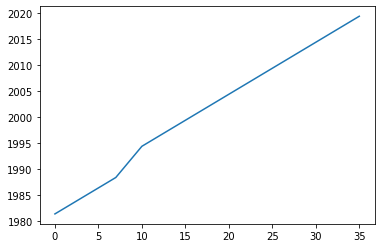

In [31]:
plt.plot(com.index)

In [32]:
cap_cum = com.capacity.cumsum()

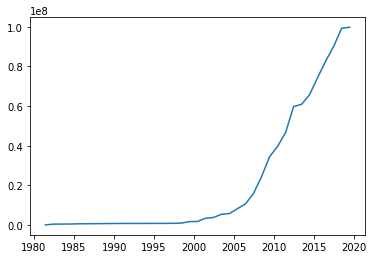

In [33]:
plt.plot(cap_cum)

In [35]:
cap_cum[1:].values>=cap_cum[:-1].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [36]:
dr = pd.date_range('1/1/2000','31/12/2018 23:00:00',freq = 'h')

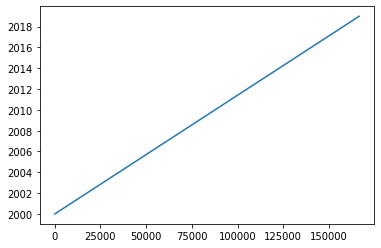

In [38]:
plt.plot(dr)

In [39]:
cap_ts = pd.Series(dr.map(cap_cum),index = dr)

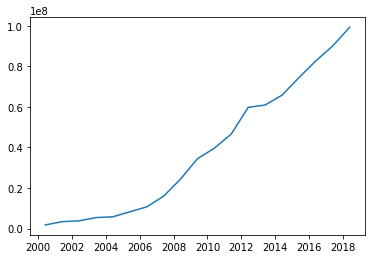

In [46]:
plt.plot(cap_ts.dropna())

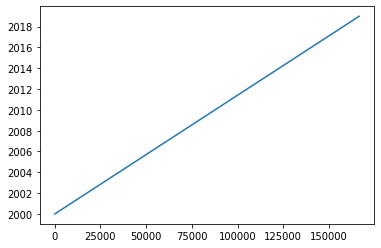

In [48]:
plt.plot(cap_ts.index)

In [49]:
cap_ts[0] = cap_cum[cap_cum.index<=pd.Timestamp('2000-01-01')].max()

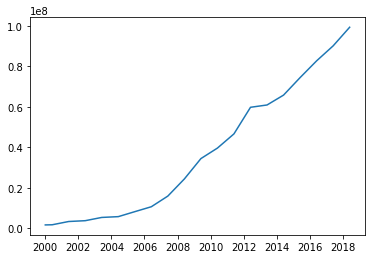

In [51]:
plt.plot(cap_ts.dropna())

In [52]:
ret = cap_ts.fillna(method='ffill')

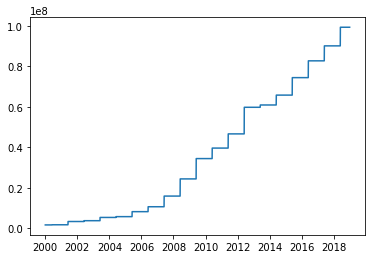

In [53]:
plt.plot(ret)

In [54]:
t = get_cap_df(turb_mer.capacity.values,
                     turb_mer.commissioning.values).tz_localize('UTC').tz_convert('US/Central')

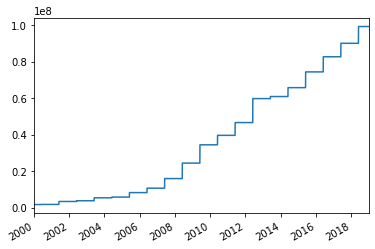

In [55]:
t.plot()

In [62]:
t1 = pd.Series(1,index=t.index)

In [65]:
t2 = t1.resample('M').sum()

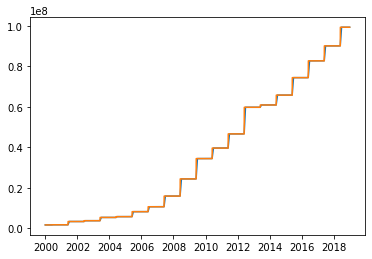

In [66]:
plt.plot(cap_usam/t2)
plt.plot(t)

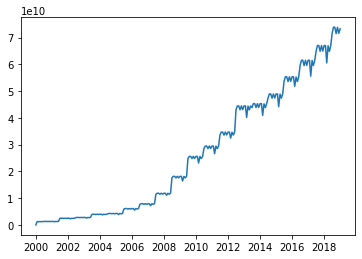

In [67]:
plt.plot(cap_usam)

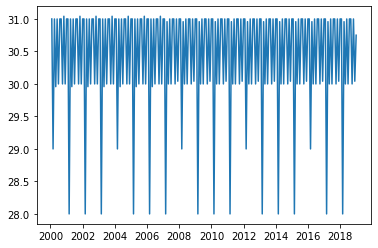

In [70]:
plt.plot(t2[1:]/24)

In [2]:
### Prepare wind park data - Installed capacities

# get aggregated turbine data
turb_mer = pd.read_csv(usa_path + "/turbine_data_mer.csv",parse_dates = ['commissioning']).drop('Unnamed: 0',axis=1)
# get capacities time series for all regions
cap_usa = get_cap_df(turb_mer.capacity.values,
                     turb_mer.commissioning.values).tz_localize('UTC').tz_convert('US/Central')
# aggregate daily or monthly where needed
cap_usam = cap_usa.resample('M').sum()

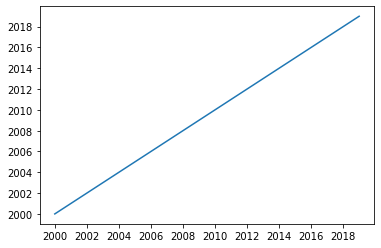

In [23]:
plt.plot(pd.date_range(start=min(cap_usam.index),end=max(cap_usam.index),freq='M'),cap_usam.index)

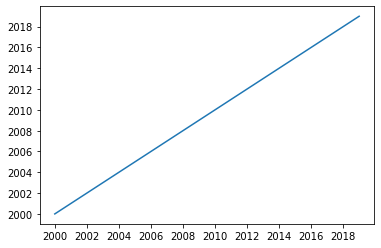

In [22]:
plt.plot(pd.date_range(start=min(cap_usa.index),end=max(cap_usa.index),freq='H'),cap_usa.index)

In [3]:
### Analysis capacity factors

## USA monthly
# Load production data
# Source: https://www.eia.gov/electricity/data/browser/#/topic/0?agg=1,0,2&fuel=008&geo=vvvvvvvvvvvvo&sec=o3g&linechart=ELEC.GEN.WND-US-99.M~ELEC.GEN.WND-IA-99.M~ELEC.GEN.WND-TX-99.M&columnchart=ELEC.GEN.WND-US-99.M~ELEC.GEN.WND-IA-99.M~ELEC.GEN.WND-TX-99.M&map=ELEC.GEN.WND-US-99.M&freq=M&start=200101&end=201903&chartindexed=0&ctype=linechart&ltype=pin&rtype=s&pin=&rse=0&maptype=0
prod_USAm = pd.read_csv(usa_path+"/generation_data/USA_monthly/Net_generation_wind_all_sectors_monthly.csv",header=4)
# arrange data
# rename columns
prod_USAm.columns = ['time','wp_obs','Iowa','Texas']
# sort indices
prod_USAm = prod_USAm[~np.isnan(prod_USAm.wp_obs)].sort_index(axis=0 ,ascending=False)
# create datetime index
prod_USAm = prod_USAm.set_index(pd.to_datetime(prod_USAm.time.values)).drop(['time'],axis=1)
# cut after 2018
prod_USAm = prod_USAm[prod_USAm.index < np.datetime64("2019-01-01")].tz_localize('US/Central')
# Prepare simulated data
# load data
wpE = xr.open_dataset(results_path+"/windpower_USA_ERA5.nc").to_dataframe()
wpE_GWA = xr.open_dataset(results_path+"/windpower_USA_ERA5_GWA.nc").to_dataframe()
wpM = xr.open_dataset(results_path+"/windpower_USA_MERRA2.nc").to_dataframe()
wpM_GWA = xr.open_dataset(results_path+"/windpower_USA_MERRA2_GWA.nc").to_dataframe()
# merge data
wp_USA = pd.concat([wpE,wpE_GWA,wpM,wpM_GWA],axis=1).tz_localize('UTC').tz_convert('US/Central')
wp_USA.columns = ['ERA5','ERA5_GWA','MERRA2','MERRA2_GWA']
# aggregate monthly
wp_USAm = wp_USA.resample('M').sum()
# combine data
comp_USAm = pd.concat([wp_USAm,prod_USAm.resample('M').sum().wp_obs*10**6],axis=1)
# calculate capacity factors
cf_USAm = comp_USAm.div(cap_usam,axis=0).dropna()

In [4]:
wp_USAm.head()

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA
time,,,,
2000-11-30 00:00:00-06:00,2.744725e+06,4.003193e+06,2.290520e+06,2.067297e+06
2000-12-31 00:00:00-06:00,2.983490e+08,5.119531e+08,3.104818e+08,3.573730e+08
2001-01-31 00:00:00-06:00,3.083108e+08,5.135866e+08,3.020111e+08,3.425138e+08
2001-02-28 00:00:00-06:00,3.157166e+08,5.327898e+08,2.739761e+08,3.197492e+08
2001-03-31 00:00:00-06:00,2.764403e+08,5.403180e+08,2.496775e+08,2.970280e+08


In [5]:
comp_USAm.head()

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,wp_obs
time,,,,,
2000-11-30 00:00:00-06:00,2.744725e+06,4.003193e+06,2.290520e+06,2.067297e+06,NaN
2000-12-31 00:00:00-06:00,2.983490e+08,5.119531e+08,3.104818e+08,3.573730e+08,389250000.0
2001-01-31 00:00:00-06:00,3.083108e+08,5.135866e+08,3.020111e+08,3.425138e+08,431242000.0
2001-02-28 00:00:00-06:00,3.157166e+08,5.327898e+08,2.739761e+08,3.197492e+08,532120000.0
2001-03-31 00:00:00-06:00,2.764403e+08,5.403180e+08,2.496775e+08,2.970280e+08,684695000.0


In [6]:
cf_USAm.head()

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,wp_obs
2000-12-31 00:00:00-06:00,0.226561,0.388769,0.235775,0.271383,0.295590
2001-01-31 00:00:00-06:00,0.234126,0.390009,0.229342,0.260099,0.327478
2001-02-28 00:00:00-06:00,0.265438,0.447941,0.230344,0.268828,0.447378
2001-03-31 00:00:00-06:00,0.209924,0.410309,0.189601,0.225558,0.519946
2001-04-30 00:00:00-05:00,0.262143,0.514915,0.284950,0.339055,0.498998


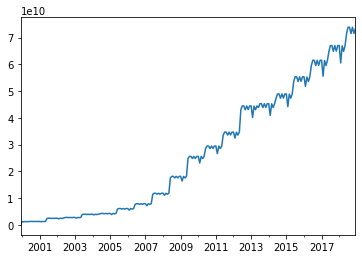

In [10]:
cap_usam.plot()

In [14]:
389250000 / 0.295590 /10**9


1.3168578098041206

In [15]:
3.573730e+08 / 0.271383 / 10**9

1.3168584620259929